# 🧠 Day 8 – CNN Image Classification with CIFAR-10
## In this project, we aim to:
* Build a Convolutional Neural Network (CNN) to classify 32x32 color images.
* Understand Conv2D, MaxPooling2D, Flatten, Dense, Dropout layers.
* Train and evaluate the model using the CIFAR-10 dataset.
* Visualize accuracy and loss during training.
* Assess performance using accuracy and confusion matrix.


In [32]:
# Import all required libraries at the start

import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Data Loading Functions 

LOCAL_DATA_DIR = 'cifar-10-batches-py'  # Folder with CIFAR-10 batches

# Function to decide loading local vs downloading
def load_cifar10_data():
    if os.path.isdir(LOCAL_DATA_DIR):
        print(f"Loading CIFAR-10 dataset from local folder '{LOCAL_DATA_DIR}'...")
        (X_train, y_train), (X_test, y_test) = load_cifar10_data_local(LOCAL_DATA_DIR)
    else:
        print("Local CIFAR-10 folder not found. Downloading dataset from the internet...")
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
        y_train = y_train.flatten()
        y_test = y_test.flatten()
    return (X_train, y_train), (X_test, y_test)

# Function to load all training batches + test batch locally
def load_cifar10_data_local(data_dir):
    X_train = []
    y_train = []
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        X, Y = load_cifar10_batch(batch_file)
        X_train.append(X)
        y_train.append(Y)
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    X_test, y_test = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))
    return (X_train, y_train), (X_test, y_test)

# Function to load one batch of CIFAR-10 data
def load_cifar10_batch(batch_path):
    with open(batch_path, 'rb') as file:
        batch = pickle.load(file, encoding='bytes')
        X = batch[b'data']
        Y = batch[b'labels']
        X = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        return X, np.array(Y)

# Load the Data

(X_train, y_train), (X_test, y_test) = load_cifar10_data()

print(f"Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")


Loading CIFAR-10 dataset from local folder 'cifar-10-batches-py'...
Train data shape: (50000, 32, 32, 3), Train labels shape: (50000,)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000,)


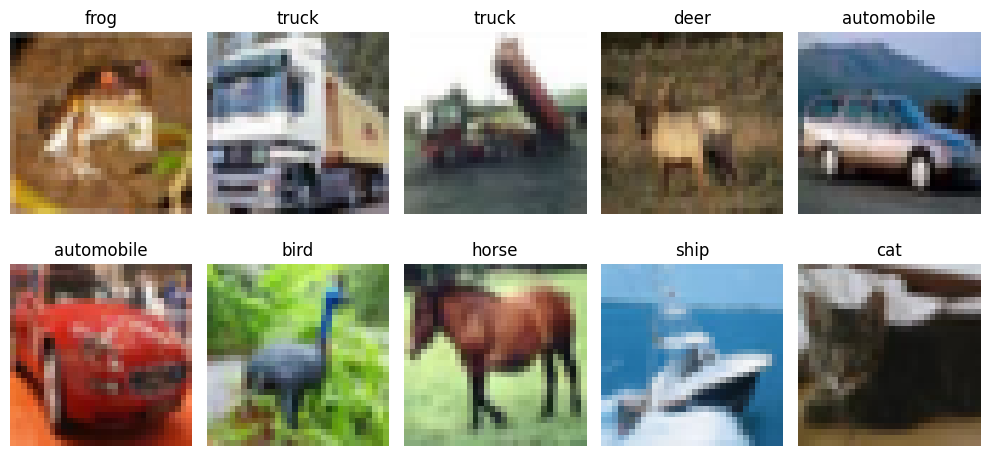

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


In [33]:
# Explore and Visualize CIFAR-10 Dataset

# Class labels for each index
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Show 10 random images with their labels
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

# 🎯 Normalize image pixel values from 0–255 → 0–1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# 🔁 Convert labels to one-hot encoded format
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Verify shape after one-hot encoding
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



In [34]:
print(y_train[0]) # One hot encoded for frog

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [35]:
# Build the CNN Model
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),  # Input layer

# 1st Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

# 2nd Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

# 3rd Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),

# Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

# Print model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 357,706 (1.36 MB)

 Trainable params: 357,258 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [40]:
# Compile the model
model.compile(
    optimizer='adam',                     # Optimizer to update weights
    loss='categorical_crossentropy',      # Loss function for multi-class classification with one-hot labels
    metrics=['accuracy']                  # Metric to monitor during training
)

# Train the model
history = model.fit(
    X_train, y_train,                     # Training data and labels
    epochs=20,                           # Number of times to iterate over the entire dataset
    batch_size=64,                       # Number of samples per training batch
    validation_split=0.2,                # 20% of training data used for validation
    verbose=1                           # Show progress bar and logs
)


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.9292 - loss: 0.1978 - val_accuracy: 0.7074 - val_loss: 1.4210
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.9358 - loss: 0.1794 - val_accuracy: 0.6708 - val_loss: 1.7931
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.9423 - loss: 0.1641 - val_accuracy: 0.6989 - val_loss: 1.4942
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.9447 - loss: 0.1528 - val_accuracy: 0.7075 - val_loss: 1.4080
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.9476 - loss: 0.1466 - val_accuracy: 0.7052 - val_loss: 1.4674
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.9510 - loss: 0.1414 - val_accuracy: 0.7231 - val_loss: 1.3457
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.9480 - loss: 0.1450 - val_accuracy: 0.7173 - val_loss: 1.4016
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.9534 - loss: 0.1360 - 

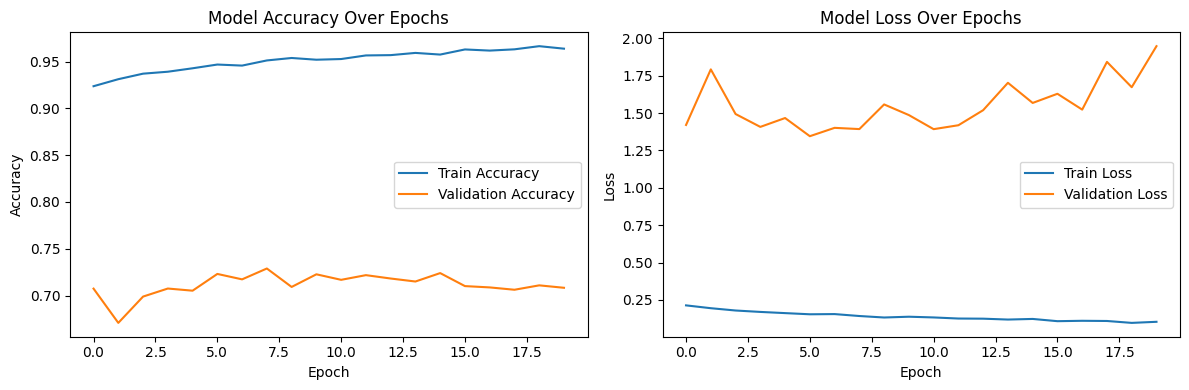

In [41]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [42]:
# Evaluate model performance on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


313/313 - 2s - 7ms/step - accuracy: 0.7057 - loss: 1.9252
Test Loss: 1.9252
Test Accuracy: 0.7057


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


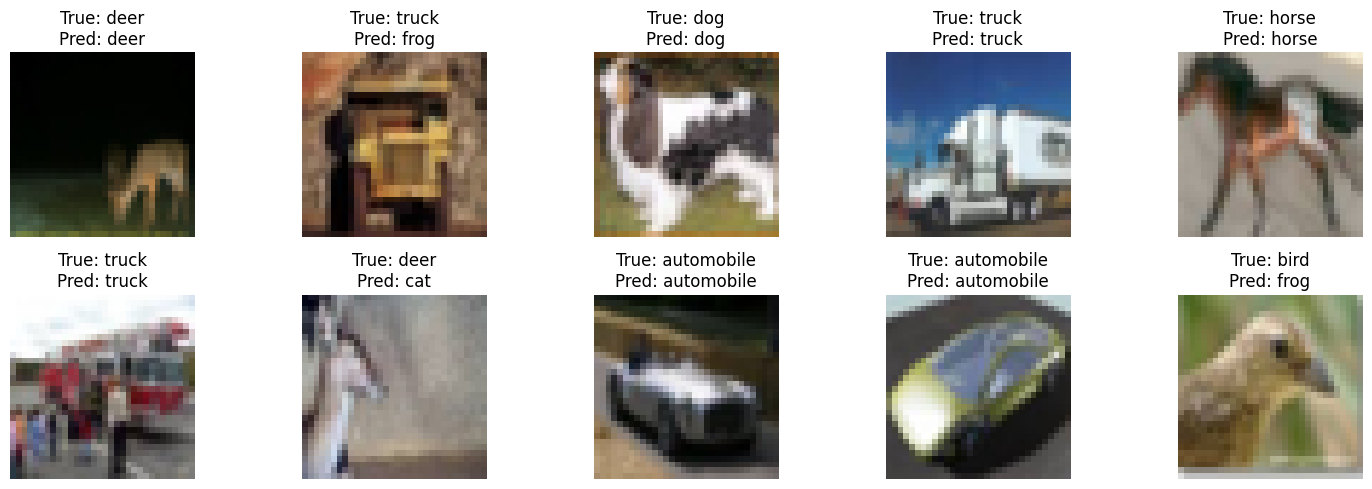

In [43]:
# Plot Some Test Images with Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

plt.figure(figsize=(15, 5))
indices = np.random.choice(len(X_test), 10, replace=False)

for i, idx in enumerate(indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred_classes[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()